# Project Airbnb Rio de Janeiro - Tool to forecast the price of a simple property

### Context:
In Airbnb, any person that has a room or a property of any kind (apartment, house, hotels, etc) can offer them to be rented per day by creating an announcement on the app. 

In the announcement, the host must describe all the features of the property, such as number of rooms, minimum daily rate, price, cancellation rules, extra fee for extra guests and among others.


### Goals:
Build a model to forecast the price that allows a person that has a property to know how much they can demand for the rent per day. The model also can help a lessor, given the property he is looking for, helps him to know if that property is at an attractive price (below average for properties with the same characteristics) or not.


### Additional information: 

- The data is available on kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro
- The prices are in BRL (R$)
- The data is from april 2918 and may 2020, with an exception from june 2018 that do not have data. 


### Initial expectations: 
The seasonality can be an important feature, because months such as december are usually more expensive. 
The location of the property will affect the price. 


## Load Data

In [2]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Import Data Basis

A dictionary will be created with the name and number of each month. The name are in portuguese to match the data. 

In [3]:
months = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

path_basis = pathlib.Path('dataset')

basis_airbnb = pd.DataFrame()

for file in path_basis.iterdir():
    name_month = file.name[:3]
    month = months[name_month]
    
    year = file.name[-8:]
    year = int(year.replace('.csv', ''))
    
    df = pd.read_csv(path_basis / file.name, low_memory=False)
    df['year'] = year
    df['month'] = month
    basis_airbnb = basis_airbnb.append(df)

display(basis_airbnb)

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Preparing Data

The table contains too many columns and this can make our model too slow. Furthermore, there are some columns that are not necessary for this analysis and they are going to be deleted.  

In [4]:
print(list(basis_airbnb.columns))
basis_airbnb.head(1000).to_csv('first_records.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [5]:
columns = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','year','month']

basis_airbnb = basis_airbnb.loc[:, columns]
print(list(basis_airbnb.columns))
display(basis_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'year', 'month']


host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Treatment of Missing Values

- Analyzing the data, it is possible to see that exist some missing values. The columns with more than 300.000 NaN values were deleted.
- Regarding the other columns, the lines with NaN valued will be deleted.

In [6]:
for column in basis_airbnb:
    if basis_airbnb[column].isnull().sum() > 300000:
        basis_airbnb = basis_airbnb.drop(column, axis=1)
print(basis_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
year                           0
month                          0
dtype: int64


Delete the empty lines

In [7]:
basis_airbnb = basis_airbnb.dropna()

print(basis_airbnb.shape)
print(basis_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
year                        0
month                       0
dtype: int64


### Verify the data types in each column

In [8]:
print(basis_airbnb.dtypes)
print('-'*60)
print(basis_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int64
month                         int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

The column price and extra people are being recognized as an object (instead of a float). Therefore, this need to be changed. 

In [9]:
#price
basis_airbnb['price'] = basis_airbnb['price'].str.replace('$', '')
basis_airbnb['price'] = basis_airbnb['price'].str.replace(',', '')
basis_airbnb['price'] = basis_airbnb['price'].astype(np.float32, copy=False)
#extra people
basis_airbnb['extra_people'] = basis_airbnb['extra_people'].str.replace('$', '')
basis_airbnb['extra_people'] = basis_airbnb['extra_people'].str.replace(',', '')
basis_airbnb['extra_people'] = basis_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(basis_airbnb.dtypes)

<ipython-input-9-509022ab0e9a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  basis_airbnb['price'] = basis_airbnb['price'].str.replace('$', '')
<ipython-input-9-509022ab0e9a>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  basis_airbnb['extra_people'] = basis_airbnb['extra_people'].str.replace('$', '')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int64
month                         int64
dtype: object


### Exploratory Data Analysis and Treatment of Outliers

Each feature will be analyzed: 
- The correlation between them and decide if we are going to keep them all
- Delete Outliers (as a rule, values below (Q1 - 1.5x Amplitude) and above (Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
- Confirm if all the features that we have really make sense to the machine learning model or if some of them will not be useful. 

<AxesSubplot:>

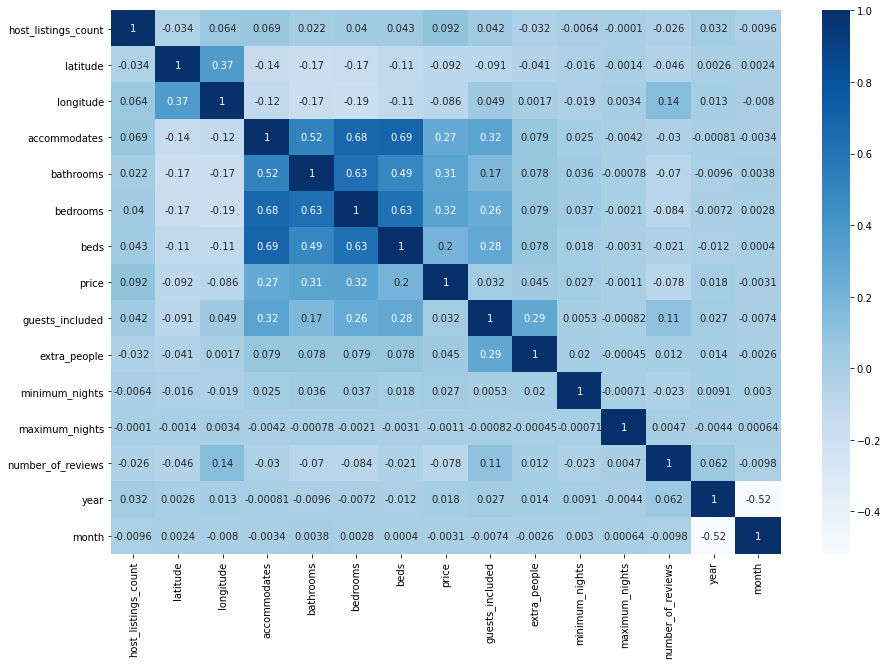

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(basis_airbnb.corr(), annot=True, cmap='Blues')

### Create functions to treat the outliers

In [12]:
def limits(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def delete_outliers(df, name_column):
    number_lines = df.shape[0]
    lim_inf, lim_sup = limits(df[name_column])
    df = df.loc[(df[name_column] >= lim_inf) & (df[name_column] <= lim_sup), :]
    deleted_lines = number_lines - df.shape[0]
    return df,  deleted_lines

In [21]:
def box_diagram(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limits(column))
    sns.boxplot(x=column, ax=ax2)
    
def histogram(column):
    plt.figure(figsize=(15, 5))
    sns.distplot(column, hist=True)

def bar_graph(column):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limits(column))

### 1º Feature: price

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


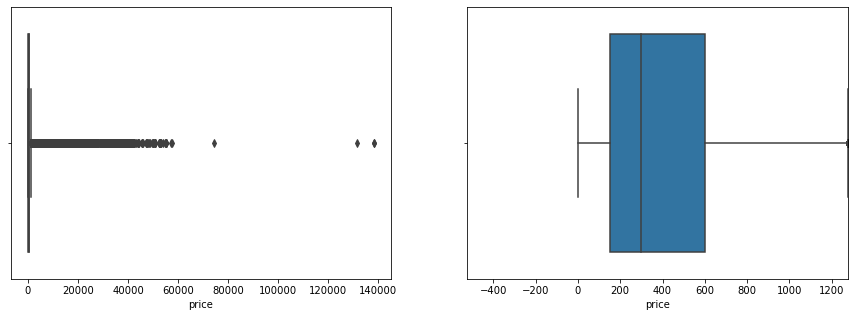

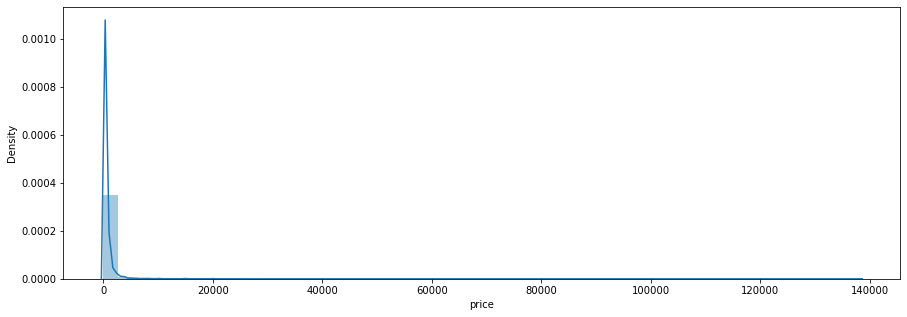

In [14]:
box_diagram(basis_airbnb['price'])
histogram(basis_airbnb['price'])

The model that we are building is for common people. For this reason, values above the superior limit will be luxurious  properties, which is not our main goal

In [16]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'price')
print('{} lines were deleted'.format(deleted_lines))

28567 lines were deleted


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(781860, 23)


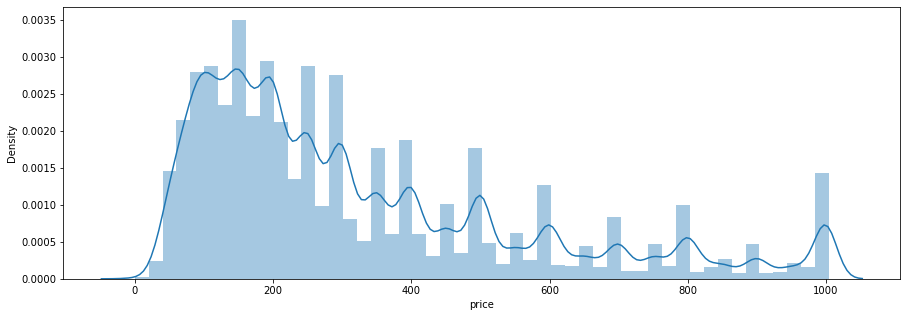

In [17]:
histogram(basis_airbnb['price'])
print(basis_airbnb.shape)

### 2º Feature) extra_people

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


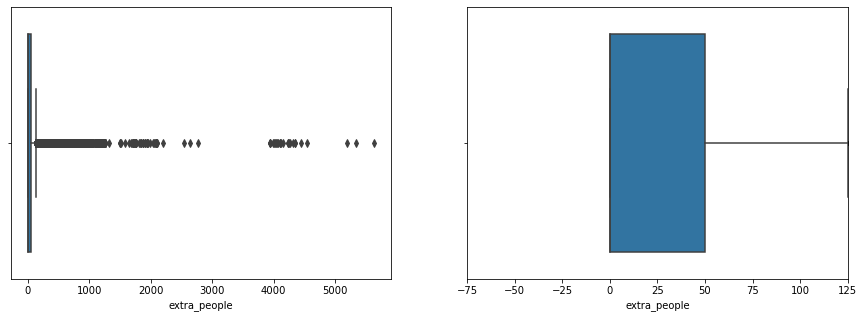

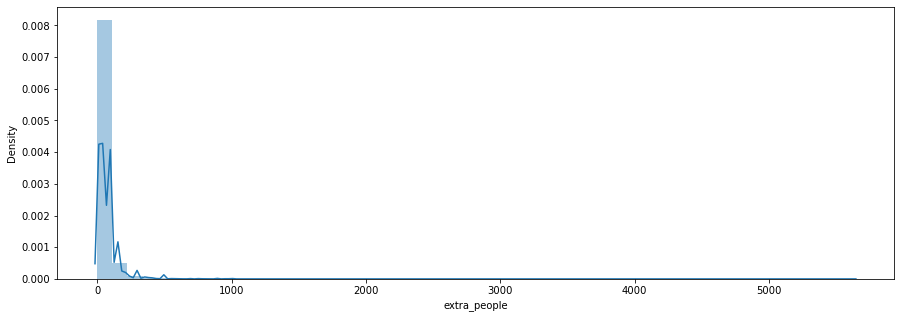

In [18]:
box_diagram(basis_airbnb['extra_people'])
histogram(basis_airbnb['extra_people'])

In [19]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'extra_people')
print('{} lines were removed'.format(deleted_lines))

55400 lines were removed


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(726460, 23)


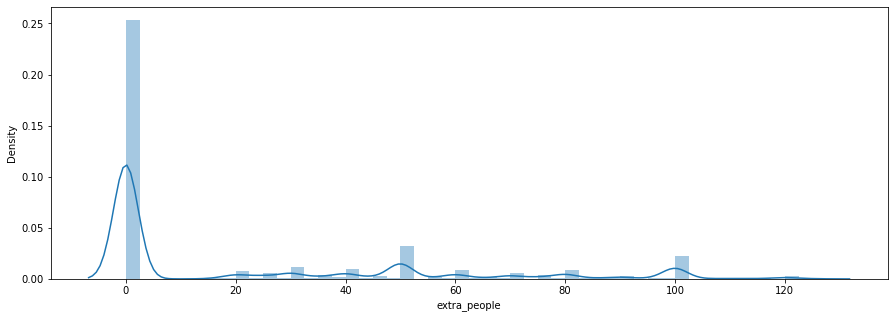

In [20]:
histogram(basis_airbnb['extra_people'])
print(basis_airbnb.shape)

### 3º Feature: host_listings_count

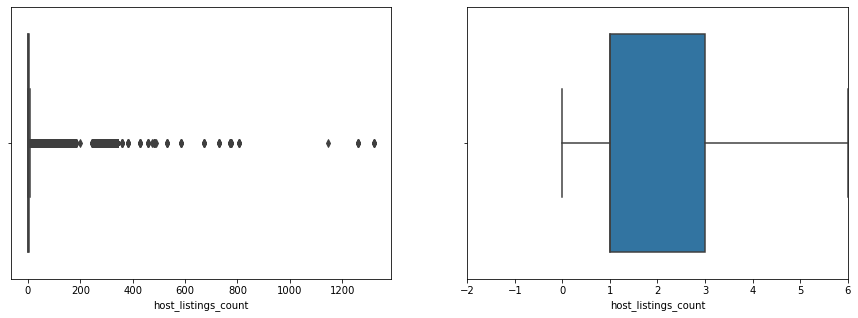

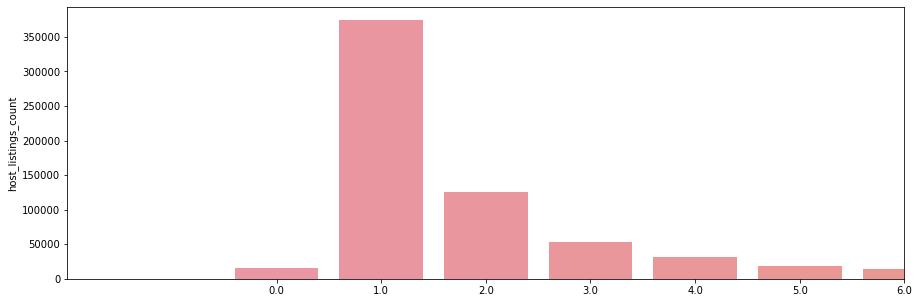

In [22]:
box_diagram(basis_airbnb['host_listings_count'])
bar_graph(basis_airbnb['host_listings_count'])

The outliers can be deleted, because hosts with more than 6 properties are not the target public of the project. 

In [23]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'host_listings_count')
print('{} lines were removed'.format(deleted_lines))

94949 lines were removed


### 4º Feature: accommodates

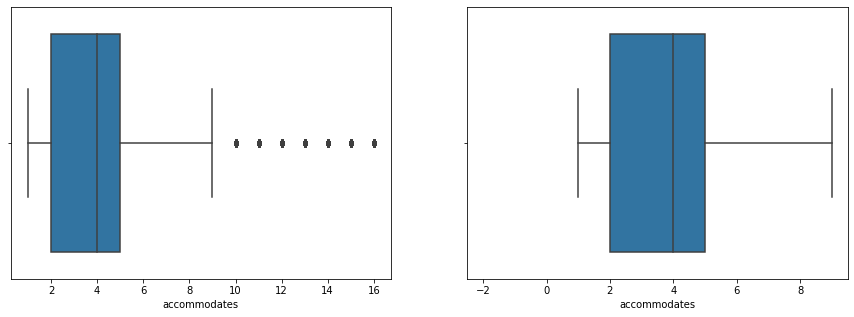

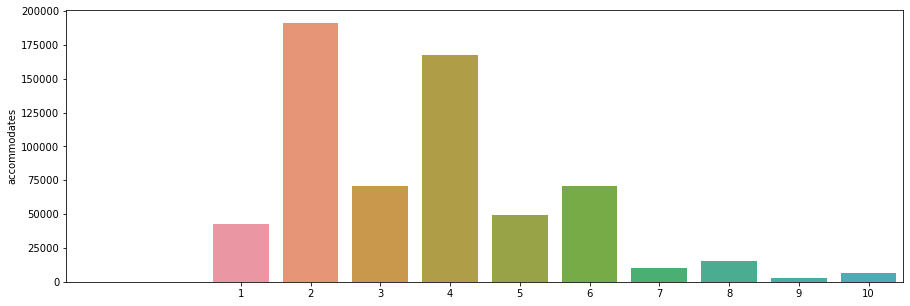

In [24]:
box_diagram(basis_airbnb['accommodates'])
bar_graph(basis_airbnb['accommodates'])

- For the same reason of the "host_listings_count", these outliers will be deleted because properties with more than 9 people are not out target public


In [26]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'accommodates')
print('{} lines were deleted'.format(deleted_lines))

17658 lines were deleted


### 5º Feature: bathrooms 

<AxesSubplot:ylabel='bathrooms'>

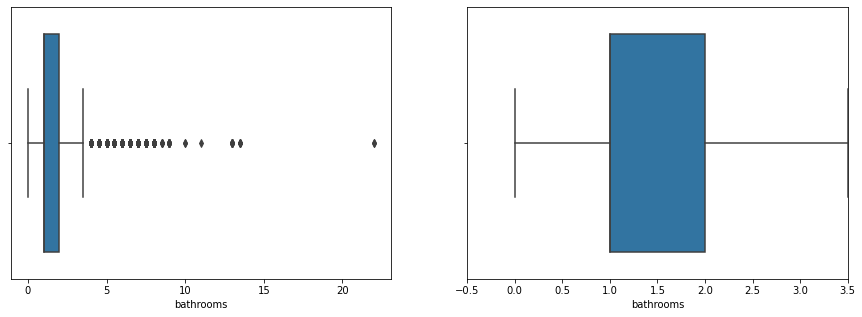

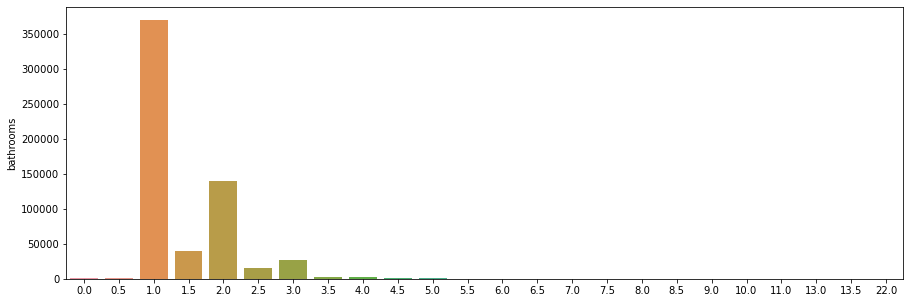

In [27]:
box_diagram(basis_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=basis_airbnb['bathrooms'].value_counts().index, y=basis_airbnb['bathrooms'].value_counts())

For the same reasons metioned above, these outliers will be deleted

In [28]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'bathrooms')
print('{} lines were removed'.format(deleted_lines))

4167 lines were removed


### 6º Feature: bedrooms

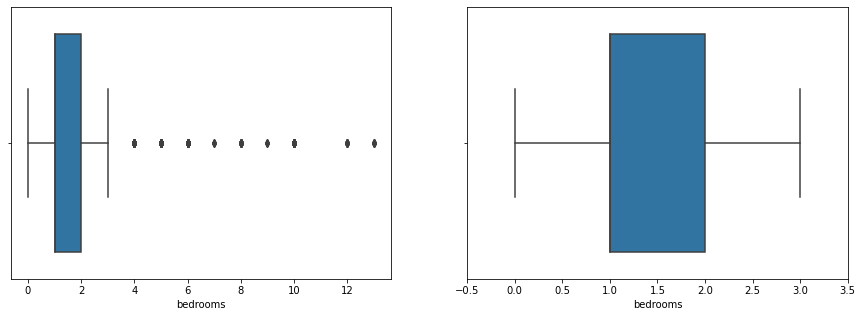

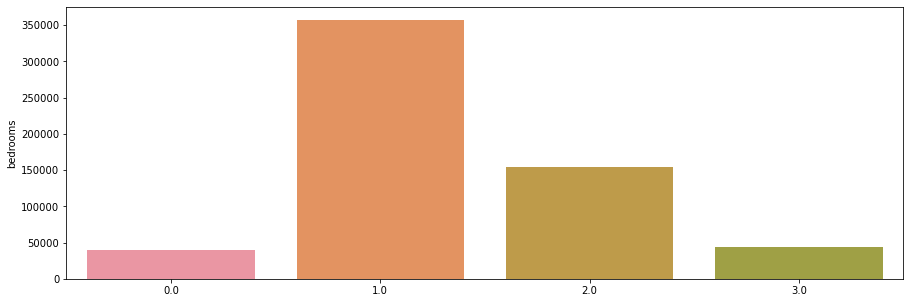

In [29]:
box_diagram(basis_airbnb['bedrooms'])
bar_graph(basis_airbnb['bedrooms'])

For the same reasons metioned above, these outliers will be deleted

In [30]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'bedrooms')
print('{} lines were removed'.format(deleted_lines))

2464 lines were removed


### 7º Feature: beds

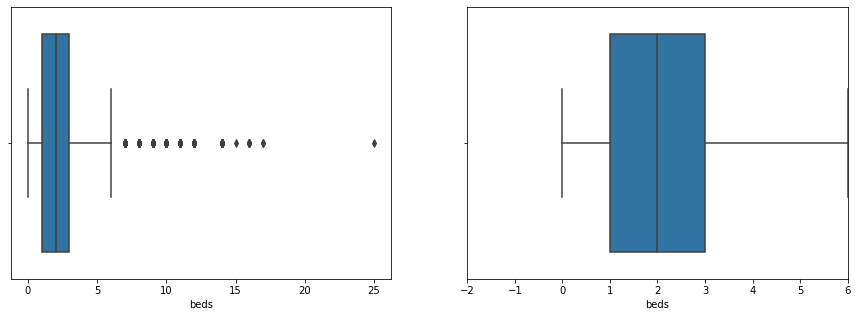

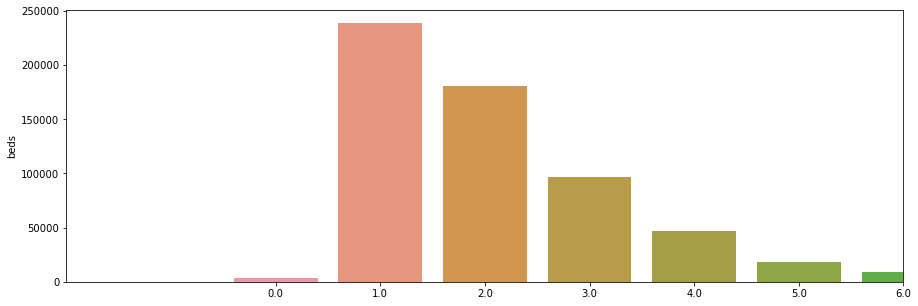

In [31]:
box_diagram(basis_airbnb['beds'])
bar_graph(basis_airbnb['beds'])

For the same reasons metioned above, these outliers will be deleted

In [32]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'beds')
print('{} lines were removed'.format(deleted_lines))

2183 lines were removed


### 8º Feature: guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

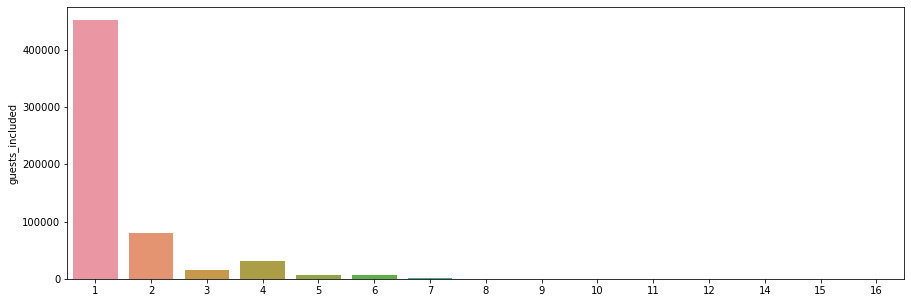

In [33]:
print(limits(basis_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=basis_airbnb['guests_included'].value_counts().index, y=basis_airbnb['guests_included'].value_counts())

This feature will be deleted because the users of airbnb utilize the pattern of 1 guest included. For this reason, the machine learning model can consider a feature that, in fact, is not essential.

In [34]:
basis_airbnb = basis_airbnb.drop('guests_included', axis=1)
basis_airbnb.shape

(593282, 22)

### 9º Feature: minimum_nights

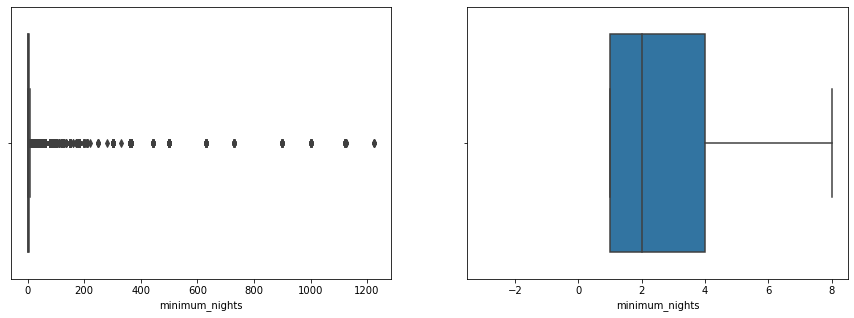

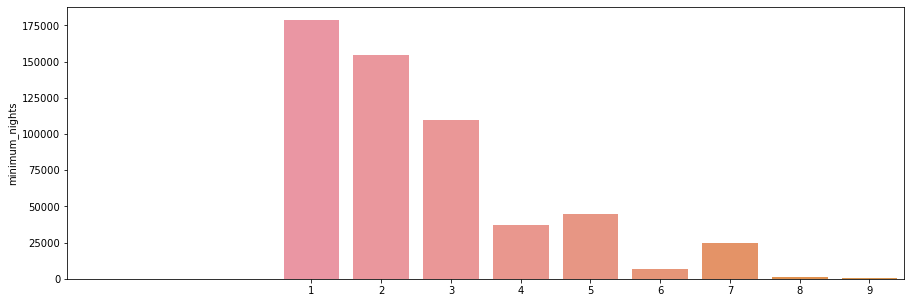

In [35]:
box_diagram(basis_airbnb['minimum_nights'])
bar_graph(basis_airbnb['minimum_nights'])

Properties with the minimum nights above 8 is not our target public because this could be season apartments or even to live in. For this reason, the outliers of this column will be deleted

In [36]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'minimum_nights')
print('{} lines were deleted'.format(deleted_lines))

35834 lines were deleted


### 10º Feature: maximum_nights

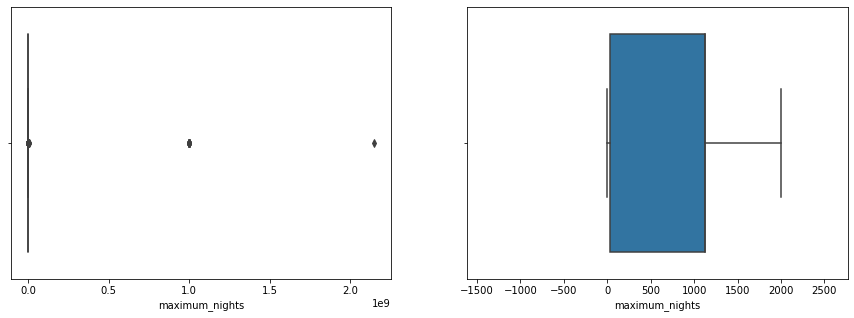

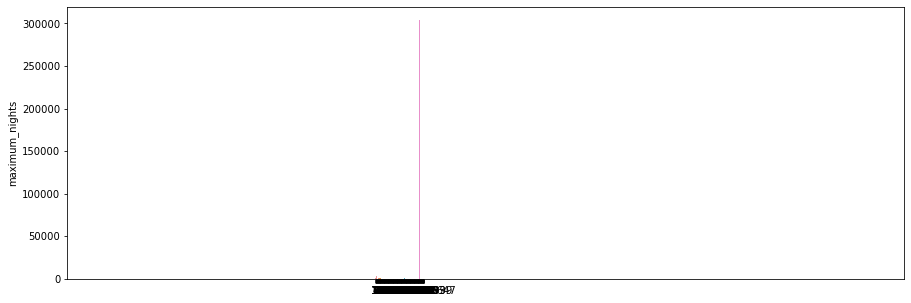

In [37]:
box_diagram(basis_airbnb['maximum_nights'])
bar_graph(basis_airbnb['maximum_nights'])

This column will not help the analysis

In [38]:
basis_airbnb = basis_airbnb.drop('maximum_nights', axis=1)
basis_airbnb.shape

(557448, 21)

### 11º Features: number_of_reviews            

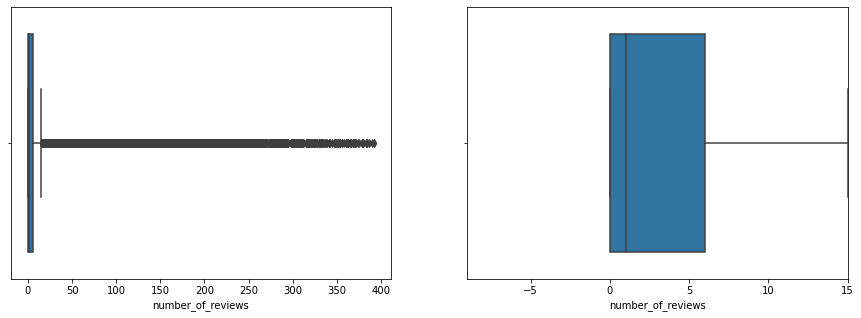

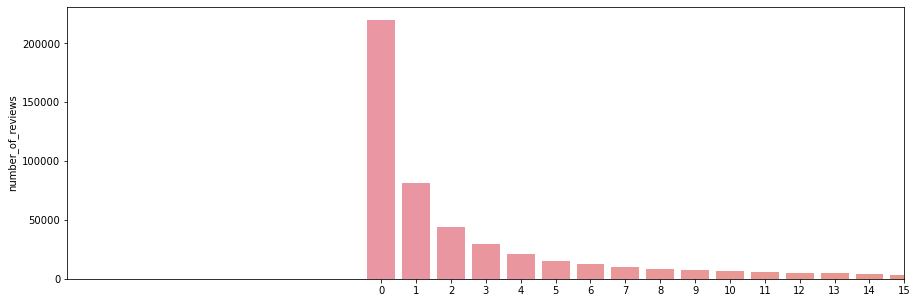

In [39]:
box_diagram(basis_airbnb['number_of_reviews'])
bar_graph(basis_airbnb['number_of_reviews'])

The machine learning model will be used for people that never rented a property but have this interest. Therefore, if a person never rented the property, there is no review.

In [40]:
basis_airbnb = basis_airbnb.drop('number_of_reviews', axis=1)
basis_airbnb.shape

(557448, 20)

### Columns with Text values

### 12º Feature: property_type 

Apartment             437791
House                  49362
Condominium            25339
Serviced apartment     12405
Loft                   12214
Outros                  8597
Guest suite             3592
Bed and breakfast       3415
Hostel                  2656
Guesthouse              2077
Name: property_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


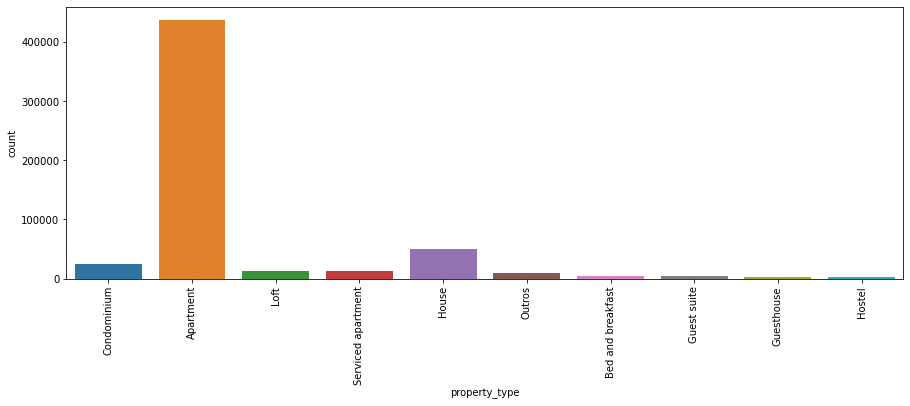

In [46]:
print(basis_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
graph = sns.countplot('property_type', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

In this case, the outliers will not be deleted but we will group the small values. 
The group called “outros” (others) will be put together, which will make the analysis easier


[]
Apartment             437791
House                  49362
Condominium            25339
Serviced apartment     12405
Loft                   12214
Outros                  8597
Guest suite             3592
Bed and breakfast       3415
Hostel                  2656
Guesthouse              2077
Name: property_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


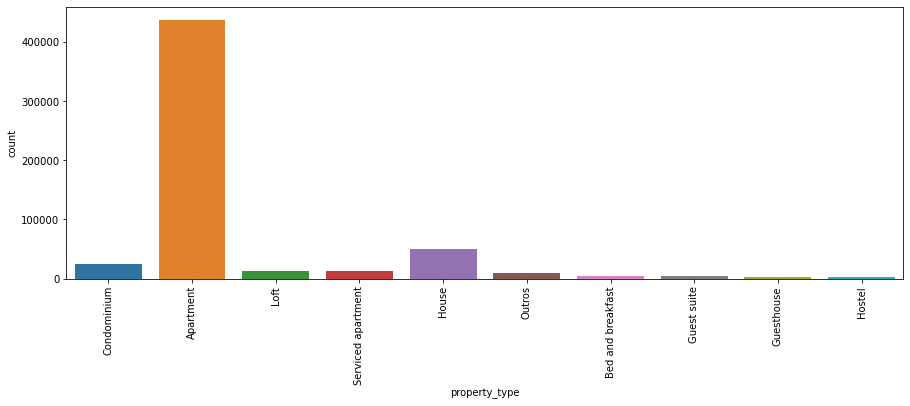

In [45]:
table_type_property = basis_airbnb['property_type'].value_counts()
group_columns = []

for type in table_type_property.index:
    if table_type_property[type] < 2000:
        group_columns.append(type)
print(group_columns)

for tipo in group_columns:
    basis_airbnb.loc[basis_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(basis_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
graph = sns.countplot('property_type', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

### 13º type: room_type 

Entire home/apt    350097
Private room       194859
Shared room         11544
Hotel room            948
Name: room_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


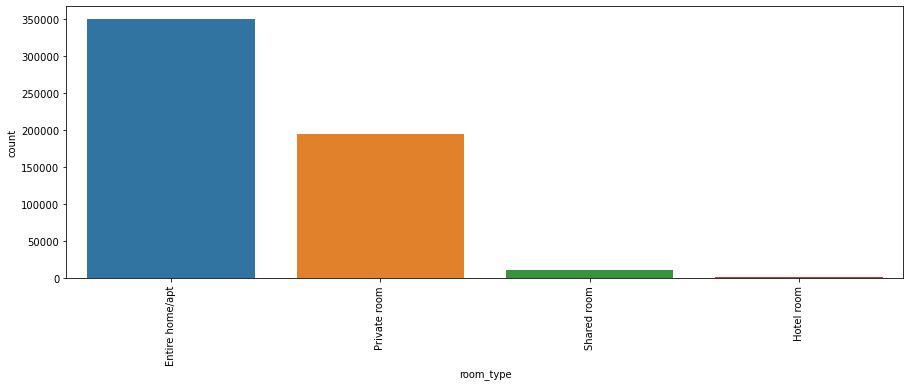

In [44]:
print(basis_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
graph = sns.countplot('room_type', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

In this feature, there is nothing to be done, it is already distributed

### 14º Feature: bed_type 

Real Bed         546328
Pull-out Sofa      7932
Futon              1605
Airbed             1111
Couch               472
Name: bed_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    546328
Outros       11120
Name: bed_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


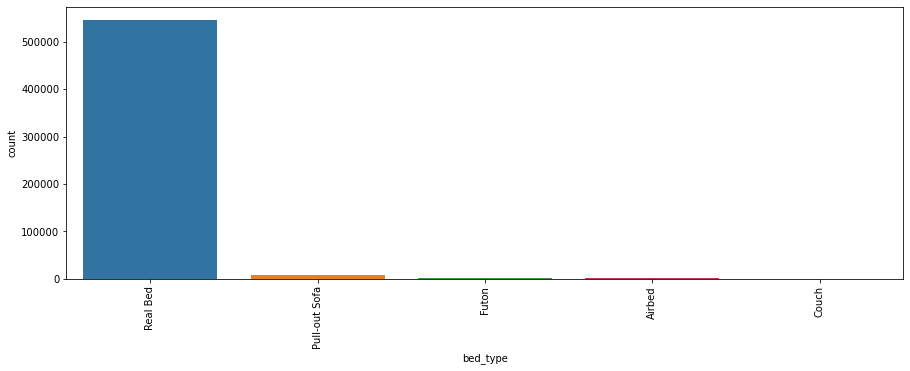

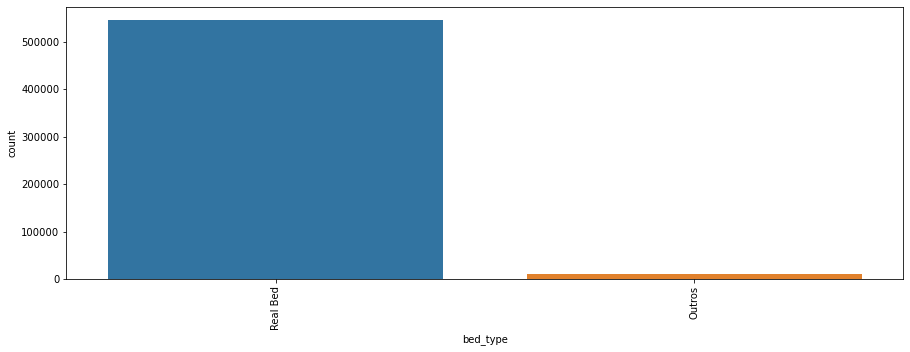

In [51]:
print(basis_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
graph = sns.countplot('bed_type', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

table_bed = basis_airbnb['bed_type'].value_counts()
group_columns = []

for typ in table_bed.index:
    if table_bed[typ] < 10000:
        group_columns.append(typ)
print(group_columns)

for typ in group_columns:
    basis_airbnb.loc[basis_airbnb['bed_type']==typ, 'bed_type'] = 'Outros'

print(basis_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
graph = sns.countplot('bed_type', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

The outliers will not be deleted but the small values will be grouped. As we have 1 value clearly higher than the others, only 2 groups of beds will be created: "Real Bed" and "others"

### 15º Feature: cancellation_policy 

flexible                       245613
strict_14_with_grace_period    192192
moderate                       110196
strict                           9297
super_strict_60                   118
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['strict', 'super_strict_60', 'super_strict_30']
flexible                       245613
strict_14_with_grace_period    192192
moderate                       110196
strict                           9447
Name: cancellation_policy, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


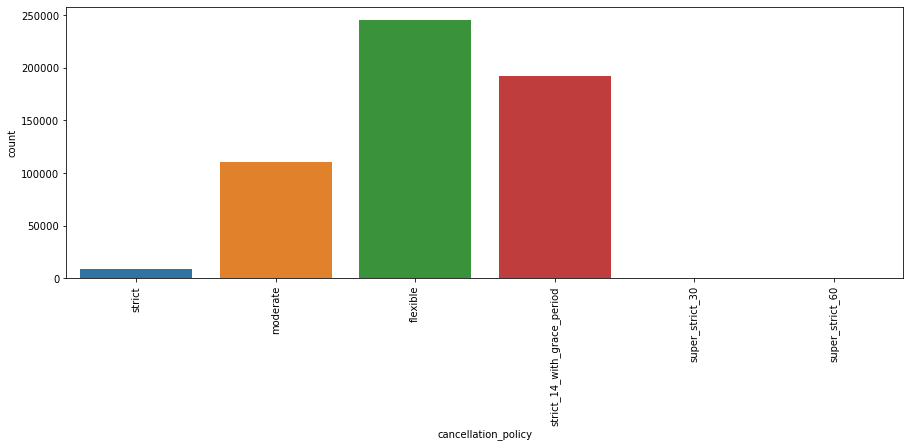

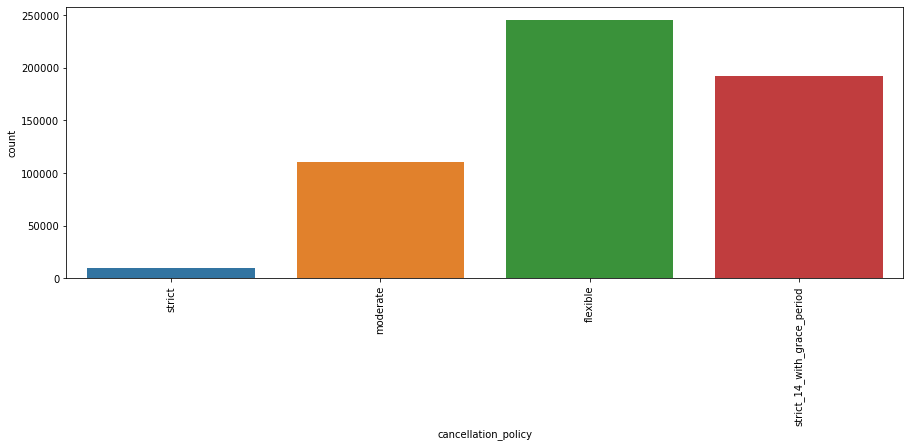

In [52]:
print(basis_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
graph = sns.countplot('cancellation_policy', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

# grouping categories
table_cancellation = basis_airbnb['cancellation_policy'].value_counts()
group_columns = []

for typ in table_cancellation.index:
    if table_cancellation[typ] < 10000:
        group_columns.append(typ)
print(group_columns)

for typ in group_columns:
    basis_airbnb.loc[basis_airbnb['cancellation_policy']==typ, 'cancellation_policy'] = 'strict'

print(basis_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
graph = sns.countplot('cancellation_policy', data=basis_airbnb)
graph.tick_params(axis='x', rotation=90)

### 16º Features: amenities 

This feature has a big range of amenities. However, the same amenities can be written in different forms. The amount of this feature will be analyzed as a parameter for the machine learning model. 

In [53]:
print(basis_airbnb['amenities'].iloc[1].split(','))
print(len(basis_airbnb['amenities'].iloc[1].split(',')))

basis_airbnb['n_amenities'] = basis_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [54]:
basis_airbnb = basis_airbnb.drop('amenities', axis=1)
basis_airbnb.shape

(557448, 20)

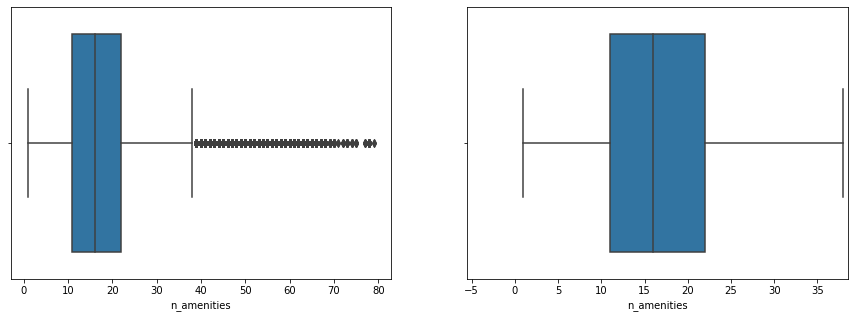

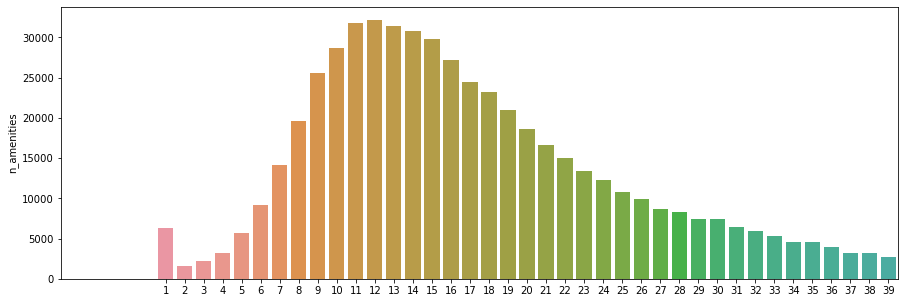

In [55]:
box_diagram(basis_airbnb['n_amenities'])
bar_graph(basis_airbnb['n_amenities'])

This column turned into a numerical value. So as the previous columns, the outliers will be deleted.

In [56]:
basis_airbnb, deleted_lines = delete_outliers(basis_airbnb, 'n_amenities')
print('{} lines were deleted'.format(deleted_lines))

23483 lines were deleted


### Visualizing Map of the properties 

The map shows a part of our data basis (approximately 50.000 properties) to illustrate how they are distributed along the city and identify the higher prices. 

In [58]:
sample = basis_airbnb.sample(n=50000)
map_center = {'lat':sample.latitude.mean(), 'lon':sample.longitude.mean()}
mapa = px.density_mapbox(sample, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=map_center, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

The features need to be adjusted to make the process easier to the machine learning model in the future.

- Features with true or false, will be replaced for 1:true and 0:false. 
- Features of category (text values), the dummies method will be used. 


In [59]:
columns_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
basis_airbnb_cod = basis_airbnb.copy()
for column in columns_tf:
    basis_airbnb_cod.loc[basis_airbnb_cod[column]=='t', column] = 1
    basis_airbnb_cod.loc[basis_airbnb_cod[column]=='f', column] = 0

In [60]:
category_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
basis_airbnb_cod = pd.get_dummies(data=basis_airbnb_cod, columns=category_columns)
display(basis_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Machine Learning Models

Evaluation Metrics

- The parameter R² will measure how good the model can explain the price, that is, how good the model is. The closer to 100%, the better.

- The Mean Square Error shows how much the machine learning model is wrong. The smaller the error, the better.


In [61]:
def evaluate_model(name_model, y_test, forecast):
    r2 = r2_score(y_test, forecast)
    RSME = np.sqrt(mean_squared_error(y_test, forecast))
    return f'Modelo {name_model}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

It will be tested the following models:
- RandomForest
- LinearRegression
- Extra Tree
   

In [62]:
model_rf = RandomForestRegressor()
model_lr = LinearRegression()
model_et = ExtraTreesRegressor()

models = {'RandomForest': model_rf,
          'LinearRegression': model_lr,
          'ExtraTrees': model_et,
          }

y = basis_airbnb_cod['price']
X = basis_airbnb_cod.drop('price', axis=1)

10% of the data basis will be tested and 90% will be trained

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for name_model, model in models.items():
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    print(evaluate_model(name_model, y_test, forecast))

Modelo RandomForest:
R²:97.11%
RSME:38.56
Modelo LinearRegression:
R²:31.54%
RSME:187.81
Modelo ExtraTrees:
R²:97.33%
RSME:37.08


The best model is the Extra Trees Regressor, which was the model with higher R² and lowest RSME. 

### Adjustments and Improvements in the Best Model

0
bedrooms                                         0.109683
latitude                                         0.105804
longitude                                        0.102527
n_amenities                                      0.090233
extra_people                                     0.087140
room_type_Entire home/apt                        0.073685
accommodates                                     0.070932
minimum_nights                                   0.065380
bathrooms                                        0.057970
beds                                             0.051783
host_listings_count                              0.041134
instant_bookable                                 0.021860
cancellation_policy_flexible                     0.018914
host_is_superhost                                0.013609
cancellation_policy_moderate                     0.013311
property_type_Apartment                          0.013177
year                                             0.011965
cancellation_policy_strict_14_with_grace_period  0.008392
property_type_House                              0.007089
property_type_Condominium                        0.005215
month                                            0.004908
room_type_Private room                           0.004805
bed_type_Outros                                  0.003138
bed_type_Real Bed                                0.002980
property_type_Outros                             0.002923
property_type_Serviced apartment                 0.002443
property_type_Loft                               0.002221
room_type_Shared room                            0.002029
property_type_Bed and breakfast                  0.001370
cancellation_policy_strict                       0.000853
property_type_Hostel                             0.000816
property_type_Guesthouse                         0.000714
property_type_Guest suite                        0.000686
room_type_Hotel room                             0.000310
is_business_travel_ready                         0.000000

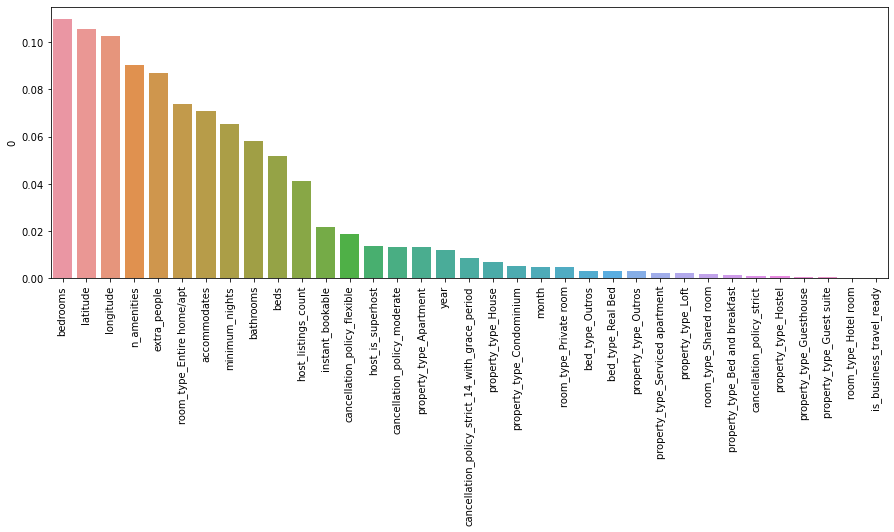

In [66]:
important_features = pd.DataFrame(model_et.feature_importances_, X_train.columns)
important_features = important_features.sort_values(by=0, ascending=False)
display(important_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=important_features.index, y=important_features[0])
ax.tick_params(axis='x', rotation=90)

### Final Adjustments

‘is_business_travel_ready’ does not have an impact on the model. Thus, to have a more simple model, this feature will be deleted.

In [68]:
base_test = basis_airbnb_cod.copy()
print(base_test.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'year', 'month',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Outros',
       'bed_type_Real Bed', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [57]:
print(forecast)

[100.99 998.54 249.2  ... 123.12 256.17 119.83]


We want to predict the price of a property that:
- it's not considered a superhost
- it's located in Copacabana, in street Santa Clara
- Accommodated 3 people
- 2 bedrooms
- 1 bathroom
- no extra people
- with no minimum nights
- it's instant bookable
- in june of 2022
- The entire apartment
- with flexible cancellation policy

In [87]:
example = {'host_is_superhost':0, 'host_listings_count': 1.0, 'latitude': (-22.972389), 'longitude': (-43.186524),
       'accommodates':3, 'bathrooms':1, 'bedrooms':2, 'beds':3,
       'extra_people':0, 'minimum_nights':0, 'instant_bookable':1, 'year':2022, 'month':6,
       'n_amenities':0, 'property_type_Apartment':1,
       'property_type_Bed and breakfast':0, 'property_type_Condominium':0,
       'property_type_Guest suite':0, 'property_type_Guesthouse':0,
       'property_type_Hostel':0, 'property_type_House':0, 'property_type_Loft':0,
       'property_type_Outros':0, 'property_type_Serviced apartment':0,
       'room_type_Entire home/apt':1, 'room_type_Hotel room':0,
       'room_type_Private room':0, 'room_type_Shared room':0, 'bed_type_Outros':0,
       'bed_type_Real Bed':1, 'cancellation_policy_flexible':1,
       'cancellation_policy_moderate':0, 'cancellation_policy_strict':0,
       'cancellation_policy_strict_14_with_grace_period':0}

forecast = pd.DataFrame(example, index=[0])

In [89]:
price = model_et.predict(example)
print(price)

[220.32]


The price of the rent per day with the conditions mentioned above is R$220.32, which is a reasonabled price for Rio de Janeiro in that time of the year. As a person who travels a lot to Rio, I can state this information.